拟牛顿方法不计算海瑟矩阵$\nabla^2f(x)$, 而是构造其近似矩阵$B^k$或者其逆的近似矩阵$H^k$. 我们希望$B^k$或者$H^k$保留了一些海瑟矩阵的性质, 例如使得$d^k$仍然为下降方向.

### 割线方程
设$f(x)$是二次可微的, 向量值函数$\nabla f(x)$在点$x^{k+1}$处的近似为：
$$\nabla f(x)=\nabla f(x^{k+1})+\nabla^2f(x^{k+1})(x-x^{k+1})+O(||x-x^{k+1}||^2)$$
令 $x = x^k, s^k = x^{k+1} − x^k$ 及 $y^k = \nabla f(x^{k+1})− \nabla f(x^k)$, 得到
$$\nabla^2f(x^{k+1})s^k+O(||s^k||^2)=y^k$$
不考虑高阶项的时候, 我们可以得到海瑟矩阵的近似$B^{k+1}$满足：
$$y^{k}=B^{k+1}s^{k}\tag{1}$$
或者其逆矩阵的近似矩阵$H^{k+1}$:
$$s^{k}=H^{k+1}y^k\tag{2}$$
我们得到的近似矩阵$B^k$仍然需要保证它是正定的！对其两边同时左乘$(s^k)^T$得到$(s^k)^Ty^{k}=(s^k)^TB^{k+1}s^{k}$, 从而有条件:
$$(s^k)^Ty^{k}>0\tag{3}$$
对于一般的目标函数, 采取Wolfe准则就会保证曲率条件(3)成立！理由：
$$\nabla f(x^{k+1})^Ts^k\geq c_2\nabla f(x^k)^Ts^k\\
(y^k)^Ts^k\geq(c_2-1)\nabla f(x^{k})^Ts^k>0$$
这是因为$c_2<1$并且$s^k=\alpha_kd^k$是下降方向.

### 一般框架 
![](1.png)

### BFGS 公式
我们这样计算近似矩阵,设$B^{k+1}=B^{k}+auu^{T}+bvv^T$, 其中$a,b\in R$待定, 根据割线方程(1):
$$B^{k+1}s^{k}=y^k=(B^{k}+auu^{T}+bvv^T)s^k$$
整理一下就有：$$(au^Ts^k)u+(bv^Ts^T)v=y^k-B^ks^k$$
直接让两边系数相等就可以得到$u,v,a,b$的公式了, 然后就可以得到$B^k$到$B^{k+1}$的更新公式
$$B^{k+1}=B^{k}+\frac{y^{k}(y^{k})^T}{(s^k)^Ty^k}-\frac{B^ks^k(B^ks^k)^T}{(s^k)^TB^ks^k}.\tag{4}$$
在问题求解过程中，条件(3) 不一定会得到满足，此时应该使用 Wolfe 准则的线搜索来迫使条件(3)成立. 我们根据这个式子并且假设$H^k=(B^k)^{-1}$可以得到：
$$H^{k+1}=(1-\rho_ky^k(s^k)^T)^TH^k(I-\rho_ky^k(s^k)^T)+\rho_ks^k(s^k)^T\tag{5}$$
其中$\rho_k=\frac{1}{(s^k)^Ty^k}$
### 有限内存的BFGS公式
首先我们引入新的记号去表示$H^{k}$的更新公式：
$$H^{k+1}=(V^k)^TH^kV^k+\rho_ks^k(s^k)^T,\tag{6}$$
其中
$$\rho_k=\frac{1}{(y^k)^Ts^k},\quad V^k=I-\rho_ky^k(s^k)^T$$
更新(6)式可以发现它有递归的特点, 于是我们可以展开$m$次
![](2.png)



很明显$H^{k-m}$还是无法显示求出来, 这个式子也不能无限展开. 我们只用一个近似的$H^{k-m}$去近似$H^{k-m}$, 这样这个式子就方便计算了. 这里给出一个算法.
$H^{k-m}$的近似矩阵可以取成$\gamma_k I$, 其中
$$\gamma_k=\frac{(s^{k-1})^{T}y^{k-1}}{(y^{k-1})^Ty^{k-1}}$$

![](2.png)

很明显$H^{k-m}$还是无法显示求出来, 这个式子也不能无限展开. 我们只用一个近似的$H^{k-m}$去近似$H^{k-m}$, 这样这个式子就方便计算了. 这里给出一个算法.
$H^{k-m}$的近似矩阵可以取成$\gamma_k I$, 其中
$$\gamma_k=\frac{(s^{k-1})^{T}y^{k-1}}{(y^{k-1})^Ty^{k-1}}$$

![](3.png)
![](4.png)

### 应用举例
#### 逻辑回归问题
$$\min_{x\in R^n} l(x)= \frac{1}{m}\sum_{i=1}^{m}ln(1+exp(-b_ia_i^Tx))+\lambda||x||_2^2$$


In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
m = 5
n = 5
A = np.random.randint(0, 10, (m,n))
B = np.random.randint(0, 10, m)
Lambda = 1/(100*m)

def sum(x):
    s = 0
    for i in range(m):
        s += np.log(1+np.exp(-B[i]*A[i]@x))
    return s
f = lambda x : (1/m)*sum(x) + Lambda*x@x

def grad_sum(x):
    s = 0
    for i in range(m):
        s += (1 - 1/(1+np.exp(-B[i]*A[i]@x))) * B[i] * A[i]
    return s
grad_f = lambda x : -(1/m)*grad_sum(x) + 2*Lambda*x

In [97]:
class quasi_Newton_method():
    def __init__(self, f, grad_f, step):
        self.f = f
        self.grad_f = grad_f
        self.step = step
    ## Wolfe criterion
    def Wolfe(self, x, d):
        alpha = 1
        while self.f(x + alpha * d) > self.f(x) + 0.1 * alpha * self.grad_f(x)@d or self.grad_f(x + alpha * d)@d < 0.9 * self.grad_f(x)@d:
            alpha = 0.5 * alpha
            if alpha < 0.01:
                break
        return alpha
    ## SR1 iteration scheme
    def SR1(self, s, y, H):
        H += ((s - H@y) @ (s - H@y)) / ((s - H@y)@y)
        return H
    ## BFGS method
    def BFGS(self, s, y, H):
        rho = 1/(s@y)
        H = np.transpose(np.eye(m) - rho * np.outer(s,y))@H@(np.eye(m) - rho * np.outer(s,y)) + rho * s@s
        return H
    ## quasi Newton method by SR1
    def solve(self):
        ## init x_0 and H_0 (or B_0)
        H = np.eye(m)
        x = np.linspace(1,10,m)
        # init the result of this method
        result = np.zeros(self.step) 
        for k in range(self.step):
            # calculate the k step's direction
            d = -(H@self.grad_f(x))
            # calculate the k step's size
            alpha =self.Wolfe(x, d)
            # calculate H_k+1
            x_next = x + alpha * d
            s = x_next - x
            y = self.grad_f(x_next) - self.grad_f(x)
            #H = self.SR1(s, y, H)
            H = self.BFGS(s, y, H)
            # store the result
            result[k] = grad_f(x_next)@grad_f(x_next)
            # init the next step
            x = x_next
        return result
    
    def double_while_BFGS(self, x, k, rho, s, y, _m, _H):
        q = self.grad_f(x[k])
        i = k - 1
        j = 1
        alpha = np.zeros(_m)
        while(i >= k - _m):
            alpha[_m-j] = rho[_m-j] * s[_m-j]@q
            q = q - alpha[_m-j] * y[_m-j]
            j = j + 1
            i = i - 1
        r = _H@q
        for i in range(k-_m, k-1):
            beta = rho[i-(k-_m)] * y[i-(k-_m)]@r
            r += (alpha[i-(k-_m)] - beta) * s[i-(k-_m)]
        return r

    def solve_L_BFGS(self):
        ## init x_0 and H_0 (or B_0)
        H = np.eye(m)
        x = np.zeros((self.step + 1, m))
        x[0] = np.linspace(1,10,m)
        # init the result of this method
        result = np.zeros(self.step)
        _m = 5 ## the length of L-BFGS
        ## 0,...,_m step, use BFGS method
        for k in range(_m):
            # calculate the k step's direction
            d = -(H@self.grad_f(x[k]))
            # calculate the k step's size
            alpha =self.Wolfe(x[k], d)
            # calculate H_k+1
            x[k+1] = x[k] + alpha * d
            s = x[k+1] - x[k]
            y = self.grad_f(x[k+1]) - self.grad_f(x[k])
            #H = self.SR1(s, y, H)
            H = self.BFGS(s, y, H)
            # store the result
            result[k] = grad_f(x[k+1])@grad_f(x[k+1])
        ## init s, y and rho and set value
        s = np.zeros((_m, m))
        y = np.zeros((_m, m))
        rho = np.zeros(_m)
        for i in range(_m):
            s[i] = x[i+1] - x[i]
            y[i] = self.grad_f(x[i+1]) - self.grad_f(x[i])
            rho[i] = 1/(y[i]@s[i])
        ## double while L-BFGS method
        for k in range(_m, self.step):
            gamma = (s[_m-1]@y[_m-1])/(y[_m-1]@y[_m-1])
            _H = gamma * np.eye(m) 
            d = -self.double_while_BFGS(x,k,rho,s,y,_m,_H)            
            alpha = self.Wolfe(x[k], d)
            x[k+1] = x[k] + alpha * d
            ## update s, y and rho
            for i in range(_m-1):
                s[i] = s[i+1]
                y[i] = y[i+1]
            s[_m-1] = x[k+1] - x[k]
            y[_m-1] = self.grad_f(x[k+1]) - self.grad_f(x[k])
            rho = np.roll(rho, -1)
            rho[_m-1] = 1/(s[_m-1]@y[_m-1])
            result[k] = grad_f(x[k+1])@grad_f(x[k+1])
        return result


In [101]:
step = 200
sol = quasi_Newton_method(f, grad_f, step)
r = sol.solve()
r2 = sol.solve_L_BFGS()

C:\User\Shen\AppData\Local\Temp\ipykernel_18256\3625004407.py:10: RuntimeWarning: overflow encountered in exp
  s += np.log(1+np.exp(-B[i]*A[i]@x))


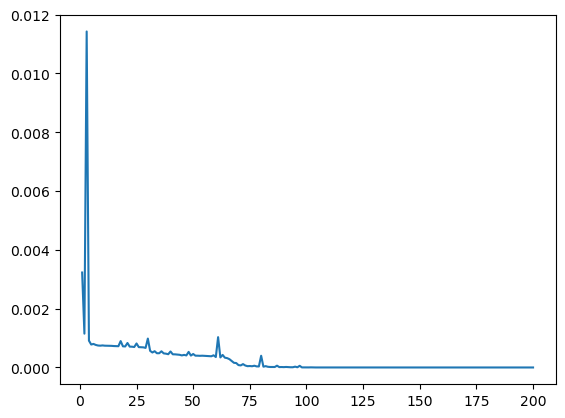

In [102]:
plt.plot(np.linspace(1,step,step), r)

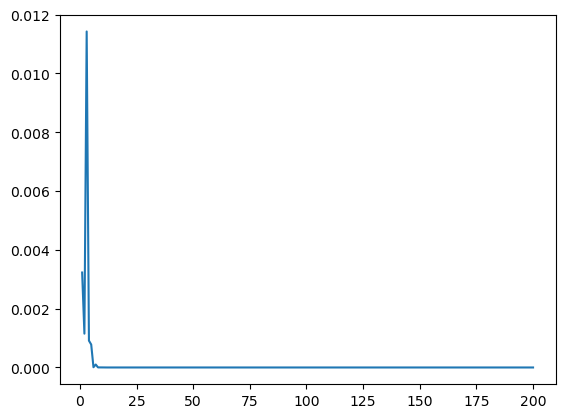

In [103]:
plt.plot(np.linspace(1,step,step), r2)

根据输出结果可以看到，使用双循环算法的结果还可以。这里纵坐标就是书中的$||\nabla l(x^k)||_{2}$

In [105]:
r2

array([3.22979813e-03, 1.15024059e-03, 1.14289076e-02, 9.12704791e-04,
       7.80588707e-04, 8.53673424e-06, 1.01067910e-04, 2.99944583e-06,
       1.55476873e-06, 1.70225939e-06, 2.57882191e-06, 1.11888677e-07,
       4.52362690e-08, 1.45482441e-08, 1.12199584e-08, 1.11713288e-09,
       2.44167588e-10, 3.16122912e-10, 6.59265661e-12, 4.44113807e-12,
       1.51730203e-13, 5.93150157e-15, 5.77322736e-16, 3.97075268e-16,
       1.50947370e-17, 1.02612687e-18, 6.63016420e-19, 1.51899716e-19,
       4.68346622e-19, 4.61547971e-19, 5.31187290e-19, 4.09036499e-19,
       4.08889825e-19, 6.22015351e-22, 9.08921360e-24, 9.05602001e-24,
       2.11703382e-23, 1.75015225e-23, 1.74228718e-23, 1.72163990e-23,
       1.71465757e-23, 2.17332718e-24, 3.08652608e-26, 9.97038358e-27,
       9.68809278e-27, 3.99171530e-27, 4.00931348e-27, 2.83484049e-27,
       1.84949561e-27, 1.84934363e-27, 3.67658513e-28, 3.66744707e-28,
       3.66059760e-28, 3.62892125e-28, 3.04746866e-28, 3.02672584e-28,
      